# Exposure at Default (EAD) and Credit Conversion Factor (CCF)

Here, we compute the **Exposure at Default (EAD)**, which represents the amount of money at risk at the moment of default.  

For this, we use the **Credit Conversion Factor (CCF)** as the target variable, defined as:

$$
\text{CCF} = \frac{\text{Loan amount} - \text{Money repaid}}{\text{Loan amount}}
$$

CCF is a **continuous variable** in the range $ (0,1) $, where:

- $ \text{CCF} = 0 $ corresponds to a perfectly good borrower  
- $ \text{CCF} = 1 $ corresponds to a perfectly bad borrower  

Unlike binary targets such as PD, we **cannot use logistic regression** here. A suitable approach is **beta regression**, which models continuous outcomes constrained between 0 and 1.

Specifically, beta regression models the conditional expected value:

$$
\mathbb{E}[\text{CCF} \mid X] = \mu(X)
$$

with a logit link function:

$$
\ln\Big(\frac{\mu(X)}{1 - \mu(X)}\Big) = \beta X
$$

where $X$ represents the set of predictor variables and $\beta$ the corresponding coefficients.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pickle

import warnings
warnings.filterwarnings("ignore")

### Import data

In [2]:
df_prep = pd.read_csv('data/loan_inputs_train.csv')
df_prep.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:67_121,mths_since_last_record:122_127,dti_factor,dti:<1,dti:1_6,dti:7_30,dti:30_40
0,269056,269056,NaN,NaN,20000,20000,20000.0,36 months,7.46,621.76,...,0,0,0,1,0,"(-0.999, 19.98]",1,0,0,0
1,499174,499174,NaN,NaN,30000,30000,30000.0,36 months,11.49,989.14,...,0,0,0,0,0,"(19.98, 39.96]",0,0,1,0
2,85143,85143,NaN,NaN,17000,17000,17000.0,60 months,6.67,333.98,...,0,0,0,0,0,"(19.98, 39.96]",0,0,1,0
3,260335,260335,NaN,NaN,24000,24000,24000.0,36 months,6.83,739.19,...,0,0,0,1,0,"(-0.999, 19.98]",0,0,1,0
4,338124,338124,NaN,NaN,30000,30000,30000.0,60 months,9.92,636.24,...,0,0,0,0,0,"(-0.999, 19.98]",0,0,1,0


Note, we will model cases only when loan was charged off, and ignore cases where borrower fully paid.

In [3]:
df_defaults = df_prep[df_prep['loan_status'].isin(['Charged Off'])]
df_defaults.shape

(6047, 325)

In [4]:
pd.options.display.max_rows = None

In [5]:
df_defaults.isnull().sum()

Unnamed: 0.1                                     0
Unnamed: 0                                       0
id                                            6047
member_id                                     6047
loan_amnt                                        0
funded_amnt                                      0
funded_amnt_inv                                  0
term                                             0
int_rate                                         0
installment                                      0
grade                                            0
sub_grade                                        0
emp_title                                      802
emp_length                                       0
home_ownership                                   0
annual_inc                                       0
verification_status                              0
issue_d                                          0
loan_status                                      0
pymnt_plan                     

### Independent variables

we fix missing values

In [6]:
df_defaults['mths_since_last_delinq'].fillna(0)

104         9.0
132         0.0
246         0.0
415         0.0
489        61.0
501         0.0
669        20.0
727         0.0
733        53.0
759         0.0
837         0.0
992         0.0
1075       32.0
1169        0.0
1218        0.0
1373        0.0
1396        0.0
1401        0.0
1412        0.0
1422       54.0
1640       29.0
1716       49.0
1736       59.0
1784       22.0
1791       46.0
1821        0.0
1941        8.0
1989       23.0
2153        0.0
2190        0.0
2224       64.0
2287       12.0
2505        0.0
2509        0.0
2638        0.0
2698       20.0
2821        0.0
3083        0.0
3117       53.0
3122        0.0
3198        0.0
3309       17.0
3317        0.0
3491       18.0
3510        0.0
3537        0.0
3679       41.0
3741       45.0
3816       21.0
3828       73.0
3925        0.0
3929        0.0
3966        0.0
3989       13.0
4037        0.0
4061       23.0
4065        5.0
4069       58.0
4418        0.0
4460       19.0
4520        0.0
4681       21.0
4698    

In [7]:
df_defaults['mths_since_last_record'].fillna(0)

104         0.0
132         0.0
246         0.0
415       111.0
489         0.0
501         0.0
669         0.0
727         0.0
733         0.0
759         0.0
837         0.0
992         0.0
1075        0.0
1169        0.0
1218        0.0
1373        0.0
1396        0.0
1401        0.0
1412        0.0
1422        0.0
1640        0.0
1716        0.0
1736        0.0
1784       55.0
1791        0.0
1821        0.0
1941        0.0
1989        0.0
2153        0.0
2190        0.0
2224        0.0
2287        0.0
2505       91.0
2509        0.0
2638       81.0
2698        0.0
2821        0.0
3083        0.0
3117        0.0
3122        0.0
3198       81.0
3309        0.0
3317        0.0
3491        0.0
3510        0.0
3537        0.0
3679        0.0
3741        0.0
3816        0.0
3828        0.0
3925        0.0
3929        0.0
3966        0.0
3989        0.0
4037        0.0
4061        0.0
4065        0.0
4069        0.0
4418        0.0
4460       69.0
4520        0.0
4681        0.0
4698    

### Dependent variable: CCF

In [9]:
df_defaults['CCF'] = (df_defaults['funded_amnt'] - df_defaults['total_rec_prncp']) / df_defaults['funded_amnt']
df_defaults['CCF'].describe()

count    6047.000000
mean        0.914510
std         0.098992
min         0.000000
25%         0.892578
50%         0.937587
75%         0.968732
max         1.000000
Name: CCF, dtype: float64

Note that, CCF is bounded within 0 and 1. Still to be safe, we clip it slightly

In [10]:
eps = 1e-4
df_defaults['CCF'] = np.clip(df_defaults['CCF'], eps, 1-eps)

In [11]:
# df_defaults.to_csv('data/df_defaults.csv')

### Explore dependent variables

Text(0.5, 0, 'CCF')

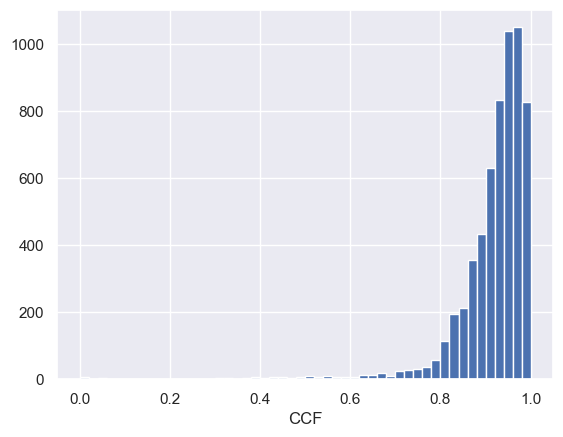

In [12]:
plt.hist(df_defaults['CCF'], bins=50)
plt.xlabel('CCF')

### Training

This part is almost same as PD model, except we use beta regression here.

In [13]:
#remove dependent variables from inputs and pass with target variable
x_train, x_test, y_train, y_test = train_test_split(df_defaults.drop(['loan_status', 'CCF'], axis=1),
                                                    df_defaults['CCF'],
                                                    test_size=0.2,
                                                    random_state=42)

In [14]:
with open('dummy_variables_revised.txt') as f:
    all_cols_revised = [line.strip() for line in f] #all columns

with open('ref_variables_revised.txt') as f:
    ref_cols_revised = [line.strip() for line in f] #reference columns (safest baseline variables)

inputs_train_w_ref_cols = x_train.loc[:, all_cols_revised]
inputs_train = inputs_train_w_ref_cols.drop(ref_cols_revised, axis=1)
inputs_train.head()

,grade:B,grade:C,grade:D,grade:E,grade:F_G,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,addr_state:MD_MI_NC,addr_state:AR,...,mths_since_last_delinq:3_16,mths_since_last_delinq:48_64,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:30_40
375967,False,True,False,False,False,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
264863,False,True,False,False,False,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
73007,False,True,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
75064,True,False,False,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
342702,False,True,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
inputs_train_num = inputs_train.apply(pd.to_numeric)
y_train = pd.to_numeric(y_train)

In [16]:
x = sm.add_constant(inputs_train_num.astype(float))
y = y_train.astype(float)

betamodel = BetaModel(y, x)
ead_model = betamodel.fit()
print(ead_model.summary())

                              BetaModel Results                               
Dep. Variable:                    CCF   Log-Likelihood:                 7093.2
Model:                      BetaModel   AIC:                        -1.408e+04
Method:            Maximum Likelihood   BIC:                        -1.375e+04
Date:                Wed, 11 Feb 2026                                         
Time:                        21:01:05                                         
No. Observations:                4837                                         
Df Residuals:                    4786                                         
Df Model:                          49                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   3.3894      0.368      9.203      0.000  

As we go high up in grades for example, coefficinets decrease, which indicate better borrowing quality

### Test

In [17]:
with open('dummy_variables_revised.txt') as f:
    all_cols_revised = [line.strip() for line in f] #all columns

with open('ref_variables_revised.txt') as f:
    ref_cols_revised = [line.strip() for line in f] #reference columns (safest baseline variables)

inputs_test_w_ref_cols = x_test.loc[:, all_cols_revised]
inputs_test = inputs_test_w_ref_cols.drop(ref_cols_revised, axis=1)
inputs_test.head()

,grade:B,grade:C,grade:D,grade:E,grade:F_G,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,addr_state:MD_MI_NC,addr_state:AR,...,mths_since_last_delinq:3_16,mths_since_last_delinq:48_64,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:30_40
353542,False,False,True,False,False,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
153469,False,True,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386168,False,False,True,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
286449,False,False,True,False,False,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
88253,False,False,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
inputs_test_num = inputs_test.apply(pd.to_numeric)
loan_target_test_num = pd.to_numeric(y_test)

tr = 0.5
X_test_const = sm.add_constant(inputs_test.astype(float))
y_pred_prob = ead_model.predict(X_test_const)  # probabilities of y=1
y_pred_class = (y_pred_prob >= tr).astype(int) 

y_pred = y_pred_prob
y_true = loan_target_test_num.astype(float)

# RMSE manually
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# R^2
r2 = r2_score(y_true, y_pred)

# MAE
mae = mean_absolute_error(y_true, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)

RMSE: 0.09657134652358637
R^2: 0.06359118464091584
MAE: 0.056235304400472


In [19]:
y_pred.describe() #is within (0,1)

count    1210.000000
mean        0.906105
std         0.024515
min         0.712455
25%         0.888819
50%         0.905373
75%         0.925414
max         0.965120
dtype: float64

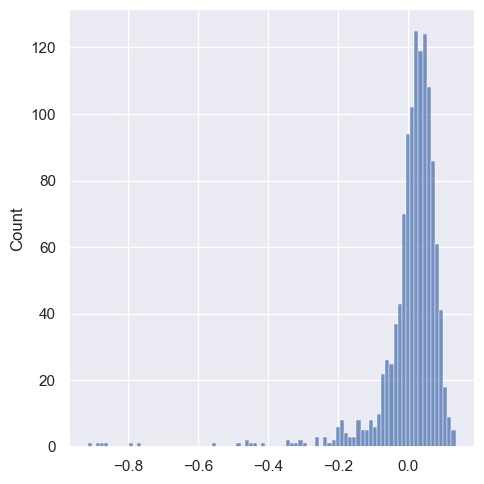

In [20]:
sns.displot(y_true-y_pred)

Residuals are normally distributed around 0, which is what we expect

In [21]:
#save model
with open('data/ead_model.pkl', 'wb') as f:
    pickle.dump(ead_model, f)